Lane Following Problem
===========================

The dynamics model of an omnidirectional vehicle with no friction is defined by the following equation:

$$
\dot{p}^x(t) = (v_k + \dot{v}_k(t-T_s k))cos(\theta_k + \theta_k(t - T_sk))
$$
$$
\dot{p}^y(t) = (v_k + \dot{v}_k(t - T_s k))sin(\theta_k + \theta_k(t - T_s k))
$$

iLQR is applied to a vehicle in order to control them to follow a reference trajectory at a terminal velocity of $10 m/s$.

The state vector $\textbf{x}$ is defined as follows:
$$\begin{equation*}
\textbf{x} = \begin{bmatrix}
    p^x & p^y & v & \theta
    \end{bmatrix}^T
\end{equation*}$$

The action vector $\textbf{u}$ is defined as follows:
$$\begin{equation*}
\textbf{u} = \begin{bmatrix}
   \dot{v} & \delta
    \end{bmatrix}^T
\end{equation*}$$

**Note**: That since this dynamics model is nonlinear, this problem can be solved
more efficiently with a simple Linear Quadratic Regulator (LQR) instead. This
example is just used to demonstrate how to setup an auto-differentiated
dynamics model.

In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function
import sys
import os
sys.path.append(os.path.abspath('../'))
import random
import ilqr
import math

In [3]:
import numpy as np
import theano.tensor as T
import matplotlib.pyplot as plt


In [4]:
from ilqr import iLQR
from ilqr.cost import PathQRCost
from ilqr.examples.car import CarDynamics, CarCost

from bc import *
import pickle

In [5]:
def on_iteration(iteration_count, xs, us, J_opt, accepted, converged):
    J_hist.append(J_opt)
    info = "converged" if converged else ("accepted" if accepted else "failed")
    final_state = xs[-1]
    final_control = us[-1]
    if iteration_count % 60 == 0:
        print("iteration", iteration_count, info, J_opt, final_state, final_control)


In [6]:
dt = 0.05
wheel_diameter = 1.0
dynamics = CarDynamics(dt, l=wheel_diameter)

An instantaneous cost function $l(\textbf{x}_t, \textbf{u}_t)$ is defined as follows:

$$
l(\textbf{x}_t, \textbf{u}_t) = \textbf{x}_t^T Q \textbf{x}_t + \textbf{u}_t^T R \textbf{u}_t
$$

where $Q$ is the state error and $R$ is the control error.

In order to approach the two vehicles to each other, $Q$ is set up to penalize differences in positions as $||\textbf{x}_0 - \textbf{x}_1||^2$ while penalizing non-zero velocities.

The following code generates the lane and boundaries. There are 150 way points along the reference trajectory. The boundary is +-3 vertically away from the reference trajecotry.S

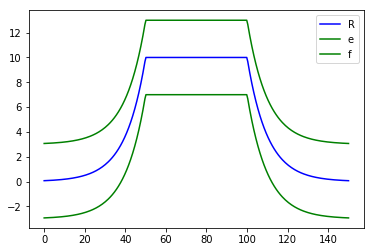

In [7]:
def lane(posx):
    ts = [50, 100, 150]
    rate = 10.0
    height = 10.0
    if posx <= ts[0]:
        return height * np.exp((posx - ts[0])/rate), np.arctan(height * np.exp((posx - ts[0])/rate)/rate)
    elif posx > ts[0] and posx <= ts[1]:
        return height * np.exp(ts[0] - ts[0]), np.arctan(0)
    elif posx > ts[1] and posx <= ts[2]:
        return height * np.exp((ts[1] - posx)/rate), np.arctan(- height * np.exp((ts[1] - posx)/rate))

def nominal(posx):
    ts = [50, 100, 150]
    rate = 10.0
    height = 10.0
    if posx <= ts[0]:
        return height * np.exp((posx - ts[0])/rate), np.arctan(height * np.exp((posx - ts[0])/rate)/rate)
    elif posx > ts[0] and posx <= ts[1]:
        return height * np.exp(ts[0] - ts[0]), np.arctan(0)
    elif posx > ts[1]:
        return height * np.exp((ts[1] - posx)/rate), np.arctan(- height * np.exp((ts[1] - posx)/rate))

def barrier_u(posx):
    return + 1 + posx, + 3 + lane(posx)[0], lane(posx)[1]
                                                                      
def barrier_l(posx):
    return - 1 + posx, - 3 + lane(posx)[0], lane(posx)[1]
    
posx_path = np.linspace(0, 150, 300)
x_path = [[posx_path[i], lane(posx_path[i])[0], 10, lane(posx_path[i])[1]] for i in range(300)]


posx_ = np.asarray(x_path)[:, 0]
posy_ = np.asarray(x_path)[:, 1]
_ = plt.plot(posx_, posy_, "b")
_ = plt.plot(posx_, posy_ + 3.0, 'g')
_ = plt.plot(posx_, posy_ - 3.0, 'g')
_ = plt.legend("Reference Path")

# Instantenous state cost.
Q = np.eye(dynamics.state_size)
Q[3, 3] = 0.0


R = np.eye(dynamics.action_size)
R[0, 0] = 1.0
R[1, 1] = 1.0

barriers = np.array([0, 1, 0, 0]) 

q = np.zeros((dynamics.state_size, 1))
r = np.zeros((dynamics.action_size, 1)) 
A = np.array([[[0, 1, 0, 0]], [[0, -1, 0, 0]]])
b = np.array([[3.0], [3.0]])
q1 = [1., 1.]
q2 = [0.1, 0.1]
#A = np.array([[[0, 1, 0, 0]]])
#b = np.array([11])

Now use iLQR to solve this trajectory following problem. Safety constraint is added such that the vehicle stay within the boundaries. The vehicles are initialized at $(0, 0)$ with velocities $10$. The look ahead horizon is 30.

In [8]:
N = len(x_path)
n = 30  # Number of time steps in trajectory.
J_hist = []
expert_traj = []

x0 = x_path[0]  # Initial state.
# Random initial action path.
#us_init = np.random.uniform(-1, 1, (n - 1, dynamics.action_size))
us_init = np.zeros((n - 1, dynamics.action_size))

for i in range(0, int(N - n) + 1):
    k = 3
    if i % k != 0:
        continue
        #pass
    x_path_ = x_path[i: i + n]
    cost = CarCost(Q = Q, q = q, R = R, r = r, A = A, b = b, q1 = q1, q2 = q2,\
                   x_nominal = x_path_,\
                   x_barrier_u = barrier_u,\
                   x_barrier_l = barrier_l)
    ilqr = iLQR(dynamics, cost, n - 1)
    xs, us = ilqr.fit(x0, us_init, on_iteration=on_iteration)

    x0 = xs[k][:]
    expert_traj = expert_traj + [[xs[i], us[i]] for i in range(k)]

iteration 0 accepted [2.86095619] [14.50765645  0.28179717 10.0079509   0.02046102] [-0.00055083 -0.00343113]
iteration 0 accepted [2.86883054] [16.01044343  0.32754796 10.00980505  0.02376484] [-0.00061831 -0.00400046]
iteration 0 accepted [2.87840518] [17.51327868  0.38072705 10.01158429  0.02766802] [-0.00068169 -0.00461776]
iteration 0 accepted [2.88998483] [19.01606555  0.4425365  10.01329065  0.03217587] [-0.00074131 -0.00535591]
iteration 0 accepted [2.90406731] [20.51868963  0.51437709 10.01493552  0.03739919] [-0.00079803 -0.00622563]
iteration 0 accepted [2.92140887] [22.02100609  0.59787484 10.01653668  0.04346835] [-0.00085302 -0.00723823]
iteration 0 accepted [2.94311062] [23.52282703  0.69491707 10.01811847  0.05052238] [-0.00090765 -0.0084157 ]
iteration 0 accepted [2.97073887] [25.02390689  0.80769398 10.01971421  0.05872231] [-0.0009637  -0.00978397]
iteration 0 accepted [3.00649858] [26.52392124  0.93874607 10.02136834  0.06825172] [-0.00102344 -0.01137569]
iteration 

/home/depend/workspace/MPSC_Guided_Imitation_Learning/ilqr/ilqr/controller.py:168: UserWarning: exceeded max regularization term
  warnings.warn("exceeded max regularization term")


iteration 0 accepted [57.73071995] [52.33319011  9.49486898 10.40643537  0.08811161] [-0.02106637  0.06832951]
iteration 0 accepted [64.35787174] [53.97266651  9.45074085 10.4263751   0.10207299] [-0.02134122  0.07597561]
iteration 0 accepted [69.43917619] [55.59566301  9.45326117 10.42322785  0.12382223] [-0.01990243  0.08099381]
iteration 0 accepted [73.00591481] [57.2013249   9.4641938  10.39891454  0.13577379] [-0.0169473   0.08796458]
iteration 0 accepted [76.00542499] [58.77692658  9.4745365  10.3634945   0.1407277 ] [-0.01326824  0.09419116]
iteration 0 accepted [79.60168611] [60.31810405  9.49610625 10.34311076  0.13713806] [-0.01093738  0.09379457]
iteration 0 accepted [78.22664246] [61.90821533  9.53642494 10.30830318  0.13471564] [-0.00790858  0.09498046]
iteration 0 accepted [70.05564208] [63.58251532  9.66850248 10.31199287  0.11272586] [-0.00850268  0.07823801]
iteration 0 accepted [60.30279446] [65.2324031   9.7765598  10.33204081  0.08064104] [-0.01056362  0.05419784]
i

TypeError: 'NoneType' object is not subscriptable

The result can be visulized by executing the following code.

In [11]:
X = []
Y = []
posx = []
posy = []
v = []
theta = []

for i in expert_traj:
    posx.append(i[0][0])
    posy.append(i[0][1])
    v.append(i[0][2])
    theta.append(i[0][3])



posx_ = np.asarray(x_path)[:, 0]
posy_ = np.asarray(x_path)[:, 1]

#pickle.dump((X, Y), open('expert_traj.p', 'wb'))

The red curve in this plot is the trajecotry of the MPC vehicle. 

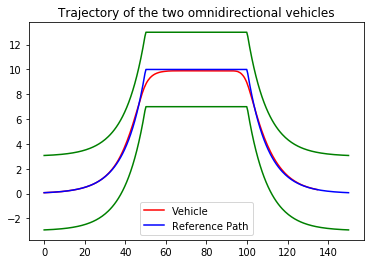

In [12]:

_ = plt.title("Trajectory of the two omnidirectional vehicles")
_ = plt.plot(posx, posy, "r")

_ = plt.plot(posx_, posy_, "b")
_ = plt.plot(posx_, posy_ + 3.0, 'g')
_ = plt.plot(posx_, posy_ - 3.0, 'g')
_ = plt.legend(["Vehicle", "Reference Path"])

In [ ]:
N = len(x_path)
H = 30  # Number of time steps in trajectory.
J_hist = []
expert_pts = []


num_pts = 50000
for pt in range(num_pts):
    x0 = [] # Initial state.
    i = random.randint(0, len(x_path) - H - 1)
    x0 = [x_path[i][0], \
          x_path[i][1] + 1.0 * (2 * random.random() - 1.0), \
          x_path[i][2] + 1.0 * (2 * random.random() - 1.0), \
          x_path[i][3] + 1.0 * (2 * random.random() - 1.0)]

    # Random initial action path.
    us_init = np.random.uniform(-1, 1, (H - 1, dynamics.action_size))
    #us_init = np.zeros((N, dynamics.action_size))
    print("Point %d" % pt)
    x_path_ = x_path[i: i + H]
    cost = CarCost(Q = Q, q = q, R = R, r = r, A = A, b = b, q1 = q1, q2 = q2,\
                   x_nominal = x_path_,\
                   x_barrier_u = barrier_u,\
                   x_barrier_l = barrier_l)
    ilqr = iLQR(dynamics, cost, H - 1)
    xs, us = ilqr.fit(x0, us_init, on_iteration=on_iteration)

    
    x_barrier_u = [i for i in x_path_[0:H]]
    for pos in x_barrier_u:
        pos[1] += 3.0
    x_barrier_l = [i for i in x_path_[0:H]]
    for pos in x_barrier_l:
        pos[1] -= 3.0
        
        
    x = [x0]
    for pos in range(H):
        if x_barrier_u[pos][1] - x_barrier_l[pos][1] != 6.0:
            exit()
        x.append(x_barrier_u[pos][:])
        x.append(x_barrier_l[pos][:])
    u = us[0]
    expert_pts = expert_pts + [[x, us[0]]]
    print(len(x))


Point 0
iteration 0 accepted [32.91410562] [20.07886314  0.48444549 10.41160891  0.25375861] [-0.00766987 -0.00348595]
61
Point 1
iteration 0 accepted [184.19566623] [25.25580286 -3.18742931  9.50929961 -0.18191954] [0.02059321 0.21048627]
61
Point 2
iteration 0 accepted [1655.87434001] [111.58492442  11.69843641   9.53506498   0.20024515] [ 0.02787355 -0.27319662]
61
Point 3
iteration 0 accepted [35.41898704] [ 2.80871942e+01  1.21928782e+00  1.01096939e+01 -5.85824866e-03] [ 0.00081029 -0.05551352]
61
Point 4
iteration 0 accepted [70.71753007] [8.51013225e+01 1.06470805e+01 9.53298676e+00 3.31379050e-02] [ 0.01335907 -0.11256305]
61
Point 5
iteration 0 accepted [109.5448564] [147.2996357   -1.66444288  10.21317483   0.67088439] [0.00671065 0.26819366]
61
Point 6
iteration 0 accepted [41.23175833] [24.81140476  0.37042109  9.63937261 -0.18141125] [0.01316967 0.00650085]
61
Point 7
iteration 0 accepted [527.12152236] [16.08914397  6.48623372 10.36594665  0.92305166] [ 0.00970678 -0.539

61
Point 65
iteration 0 accepted [24.74955474] [ 1.21255213e+02  1.27672594e+00  1.02280071e+01 -1.84240281e-02] [-0.00884321  0.04787669]
61
Point 66
iteration 0 accepted [71.83071273] [25.91102009  2.61982635 10.14989958 -0.38164453] [ 0.00950295 -0.32974808]
61
Point 67
iteration 0 accepted [92.65989073] [77.63750446 10.14736395 10.09426162 -0.14246324] [ 0.00466451 -0.02912111]
61
Point 68
iteration 0 accepted [2633.72442011] [ 1.19280575e+02 -1.22832254e-03  9.15407291e+00  4.44116747e+00] [-0.0695037  -1.28938338]
61
Point 69
iteration 0 accepted [60.28583712] [61.7820028   9.74105122 10.25716881  0.12296893] [-0.00246994  0.04921471]
61
Point 70
iteration 0 accepted [48.72272424] [ 9.86524809e+01  9.65464444e+00  9.78731488e+00 -2.88022071e-02] [0.00420024 0.05908213]
61
Point 71
iteration 0 accepted [280.09822082] [12.23569065  4.7076948  10.39676831  1.84101877] [0.09240686 0.07270973]
61
Point 72
iteration 0 accepted [12.8231475] [24.06445823  1.02921561  9.92499864 -0.386092

61
Point 127
iteration 0 accepted [191.4307041] [46.50440729  3.58195551 10.01584073  0.65047477] [0.00550697 0.08183993]
61
Point 128
iteration 0 accepted [28.65873782] [ 1.40453779e+02  1.21786667e-01  1.02746772e+01 -2.21812823e-01] [-0.00285842 -0.03329354]
61
Point 129
iteration 0 accepted [56.1541692] [125.2300303    1.59199491   9.51719863  -0.3140583 ] [ 0.02235807 -0.04618613]
61
Point 130
iteration 0 accepted [10.73077273] [32.36735287  1.79364913 10.02231822  0.23347297] [0.00434914 0.02084665]
61
Point 131
iteration 0 accepted [2835.85943251] [117.6705727    3.10208609   9.42109896  -5.20336568] [0.04749858 0.32628055]
61
Point 132
iteration 0 accepted [1351.29776793] [78.55999904 16.44829226  9.90986382  3.23327122] [ 0.01819515 -0.79061789]
61
Point 133
iteration 0 accepted [2611.56594531] [51.71234802 -1.13657263 10.51924254  1.15020144] [-0.0486179  -0.17082061]
61
Point 134
iteration 0 accepted [361.66279274] [46.23773582  7.939355    9.66991258 -0.69819452] [0.0150074

61
Point 191
iteration 0 accepted [60.75751838] [65.38744489  9.41032032 10.38024697 -0.28704443] [-0.0059541  -0.14915462]
61
Point 192
iteration 0 accepted [63.46847503] [21.08404557 -0.27993427  9.52126154  0.11259615] [0.02235221 0.17403098]
61
Point 193
iteration 0 accepted [4720.67037715] [28.2220854  -0.06512468  9.04572516 -4.00175808] [0.10043983 1.02707878]
61
Point 194
iteration 0 accepted [577.47366104] [96.98768864  3.24280692 10.04480372 -1.82937049] [0.01209044 1.02776511]
61
Point 195
iteration 0 accepted [149.75307762] [94.27655197  9.48720606 10.15860867  0.27468421] [0.003744   0.01681923]
61
Point 196
iteration 0 accepted [1624.59970082] [137.46329467  11.10235967  10.0856888    0.59923844] [ 0.0684026  -0.40615171]
61
Point 197
iteration 0 accepted [1010.09524123] [94.04639209 17.14735424  9.43044482  0.20600124] [ 0.04516315 -0.07402132]
61
Point 198
iteration 0 accepted [13.00798302] [14.53784453  0.39377061 10.19478944  0.25200634] [0.00056908 0.06364403]
61
Poi

61
Point 256
iteration 0 accepted [1941.36443868] [ 1.17415625 -7.7191235   9.66948847 -2.19596733] [-0.17480967  1.31437358]
61
Point 257
iteration 0 accepted [961.16751015] [39.15170287 -5.55189259 10.30464174 -1.41468513] [0.01213771 0.79046183]
61
Point 258
iteration 0 accepted [102.87502826] [7.19429488e+01 1.02769451e+01 1.00124063e+01 2.83087865e-02] [ 0.00282967 -0.00160832]
61
Point 259
iteration 0 accepted [1646.94686154] [115.38187696   0.5788126    9.45614566  -2.2293644 ] [ 0.03618239 -0.30292778]
61
Point 260
iteration 0 accepted [50.11463122] [8.36879243e+01 1.01373338e+01 9.83626014e+00 1.90431652e-02] [-0.00127879 -0.18228235]
61
Point 261
iteration 0 accepted [912.94812058] [48.78251872 10.89773197  9.49935224 -1.39328492] [-0.0458143   0.43902507]
61
Point 262
iteration 0 accepted [795.8179066] [24.83006781 -5.85887138 10.12986385 -1.26278712] [0.01611354 0.47498409]
61
Point 263
iteration 0 accepted [1780.71370119] [96.1941982   3.54118242  9.99709941 -2.57432014] [

iteration 60 accepted [26.20884176] [38.41778787  3.07471109 10.4531545   0.25719642] [-0.02301528  0.        ]
61
Point 322
iteration 0 accepted [378.69999537] [131.1364839    3.50589983  10.16743041  -0.24134901] [ 0.01131831 -0.10907414]
61
Point 323
iteration 0 accepted [73.36292775] [ 9.16063662e+01  9.99521532e+00  1.01047082e+01 -2.00654285e-02] [ 0.00122533 -0.10170593]
61
Point 324
iteration 0 accepted [315.64994361] [119.84650459   5.957368    10.26470723  -0.20937147] [ 0.00972432 -0.52486468]
61
Point 325
iteration 0 accepted [467.0992211] [59.9979419   4.10264195 10.12702449 -0.56112695] [0.01289398 0.63112893]
61
Point 326
iteration 0 accepted [283.42135633] [77.79444039 11.17110289  9.49893113  0.97874885] [-0.09210924  0.02465784]
61
Point 327
iteration 0 accepted [617.89311695] [56.3316503   8.00036724 10.27690642  0.9225274 ] [-0.08395223  0.53857584]
61
Point 328
iteration 0 accepted [99.35009325] [34.32376905 -0.04105772  9.85762317  0.21723951] [0.00901488 0.324384

61
Point 386
iteration 0 accepted [106.66051364] [141.84944684   1.41565216  10.20399124  -1.04760026] [ 0.00639019 -0.31414843]
61
Point 387
iteration 0 accepted [87.22769484] [88.46726366  9.62164614 10.43341408  0.36178547] [-0.00823711  0.2089525 ]
61
Point 388
iteration 0 accepted [1004.40795168] [124.30308829   9.99803396   9.73680934   1.99271915] [-0.1688646  -0.92968605]
61
Point 389
iteration 0 accepted [46.22796021] [92.72099752  9.85361868  9.79709713  0.09814668] [0.00376419 0.06864754]
61
Point 390
iteration 0 accepted [3046.79312782] [111.27007969   3.99367057  10.06482879   0.2673675 ] [-0.06789736 -0.18736253]
61
Point 391
iteration 0 accepted [2932.5444339] [91.82333012  6.2904795   9.94749971 -6.21771587] [0.0346963  1.13555501]
61
Point 392
iteration 0 accepted [90.76280167] [90.510079    9.29162256 10.11812226  0.41768882] [0.00489784 0.19886354]
61
Point 393
iteration 0 accepted [17.10559834] [23.96844629  0.69931833  9.78472193  0.04876289] [ 0.00354064 -0.018498

61
Point 451
iteration 0 accepted [113.07730727] [120.85343023   3.6017199    9.98215071   0.29475637] [ 0.00309136 -0.1981338 ]
61
Point 452
iteration 0 accepted [26.43661855] [1.36364026e+02 1.34434570e-01 1.00566685e+01 1.28499994e-01] [0.00741429 0.0460882 ]
61
Point 453
iteration 0 accepted [57.16044607] [65.18959216  9.6755541  10.05409415  0.33926344] [0.00300574 0.1867009 ]
61
Point 454
iteration 0 accepted [691.09186921] [111.87503432  12.01821988  10.20081615   0.95048489] [ 0.01300997 -0.927162  ]
61
Point 455
iteration 0 accepted [569.33419601] [106.63431531  -0.99356016   9.54591164  -0.70332588] [0.02235222 0.27843418]
61
Point 456
iteration 0 accepted [54.64443378] [93.59872042  9.65043176  9.95050345  0.170781  ] [0.00179196 0.01780458]
61
Point 457
iteration 0 accepted [110.34584205] [102.15187091   5.4366104    9.58130545  -0.65010085] [0.02547851 0.15775161]
61
Point 458
iteration 0 accepted [1236.05864898] [93.82788961 10.78825333  8.9263796  -4.69384178] [0.0376809

61
Point 516
iteration 0 accepted [2208.82453377] [62.74087226 12.10031547  9.70594836  4.05514534] [ 0.00989609 -1.59246568]
61
Point 517
iteration 0 accepted [2218.80938114] [108.43304042  12.05714447   9.44681372   1.55234986] [ 0.02925564 -1.0355283 ]
61
Point 518
iteration 0 accepted [4047.50493897] [32.07241495  0.37823207  8.74682177  5.36129187] [ 0.05788288 -1.10362617]
61
Point 519
iteration 0 accepted [33.19902311] [14.21532171 -0.33272239  9.94134458  0.30301467] [0.00829351 0.14127013]
61
Point 520
iteration 0 accepted [93.34305543] [57.16645978  8.42386197 10.16378944  0.20499688] [5.74328437e-05 1.41580660e-01]
61
Point 521
iteration 0 accepted [3801.95303523] [7.98054427 3.18142214 9.54538945 3.82562065] [ 0.06527617 -1.42606526]
61
Point 522
iteration 0 accepted [23.41750839] [44.04790589  5.23447985 10.35361145  0.30868276] [ 0.00041562 -0.10069555]
61
Point 523
iteration 0 accepted [3462.87599315] [ 1.19250049 -4.45953867  9.03862955 -5.00502731] [0.06256548 1.707280

61
Point 581
iteration 0 accepted [25.33042441] [37.78070821  2.76452201  9.88335773  0.48242487] [-0.00363676  0.02458751]
61
Point 582
iteration 0 accepted [471.53022413] [52.56911966 10.37851539  9.81540707 -1.78001523] [ 0.04959279 -0.11457664]
61
Point 583
iteration 0 accepted [259.31307708] [106.08023973   1.20494418   9.64469343  -1.21016724] [0.01391163 0.46468974]
61
Point 584
iteration 0 accepted [2647.54646871] [99.71586184 13.90020039  8.24117688  2.20687322] [0.08111114 0.09981924]
61
Point 585
iteration 0 accepted [18.0400737] [1.35293985e+02 3.44626931e-01 9.81083253e+00 7.54155214e-02] [ 0.00512206 -0.00637402]
61
Point 586
iteration 0 accepted [1539.13159159] [16.04222831  1.60844152 10.12853151 -3.32757826] [0.01838047 1.31897083]
61
Point 587
iteration 0 accepted [379.27949652] [94.63713455  7.45048592 10.38275747 -0.28187062] [-0.00680841  0.17879384]
61
Point 588
iteration 0 accepted [1509.99594619] [63.88558941 11.73447365  9.63870872  3.22309674] [ 0.0315064 -0.8

61
Point 644
iteration 0 accepted [68.31206893] [74.21485955  9.07440763  9.54977612  0.21168481] [0.02111536 0.09534958]
61
Point 645
iteration 0 accepted [62.12370157] [91.21885735 10.08017084 10.33887849 -0.11754251] [-0.00390741  0.06299892]
iteration 60 accepted [52.22824441] [9.16872039e+01 9.91569258e+00 1.03515441e+01 1.32143249e-02] [-0.01805026  0.        ]
61
Point 646
iteration 0 accepted [47.21927328] [20.30832122 -0.5871568   9.55083634 -0.03735883] [0.0147962  0.20890511]
61
Point 647
iteration 0 accepted [50.60693644] [79.34509917 10.03178786 10.2781333   0.16233455] [-0.00076152  0.03128324]
61
Point 648
iteration 0 accepted [51.56968102] [125.37195646   0.89184826   9.92069958  -0.19114843] [ 0.00392632 -0.14172042]
61
Point 649
iteration 0 accepted [121.01768221] [50.47486729  7.88459937  9.80169528  0.35244189] [0.00498033 0.14451853]
61
Point 650
iteration 0 accepted [4932.02286484] [90.41315157  8.0783993   8.51784979 -4.73065966] [0.03800555 1.30925204]
61
Point 

61
Point 709
iteration 0 accepted [267.09167763] [57.58162539  6.17305809  9.88440767  0.19141236] [0.01519076 0.34106858]
61
Point 710
iteration 0 accepted [1044.590803] [136.65959098  -1.46579031   9.89200503  -1.61408769] [0.01186774 0.28837147]
61
Point 711
iteration 0 accepted [878.08676289] [118.25615003   8.39454121   9.40763737   1.52290945] [ 0.02960349 -0.69873177]
61
Point 712
iteration 0 accepted [63.37648575] [8.98318867e+01 9.68323722e+00 1.00534188e+01 5.88808986e-02] [0.00660388 0.11490563]
61
Point 713
iteration 0 accepted [112.70127311] [43.44736026  6.08730728  9.52215905 -0.08702771] [0.01974978 0.05164261]
61
Point 714
iteration 0 accepted [121.96890429] [120.06183967   2.44330385  10.31468514  -0.32169494] [ 0.00036846 -0.18581614]
61
Point 715
iteration 0 accepted [43.5866701] [14.98832306 -0.27750267  9.55099697 -0.02479383] [0.00677391 0.04323763]
61
Point 716
iteration 0 accepted [1016.23224446] [59.55765163 16.97537637  9.98251134  1.65125723] [ 0.0243879 -0.

61
Point 773
iteration 0 accepted [27.55771857] [46.42715069  6.06989057 10.13505166  0.61018436] [0.00250392 0.27472294]
61
Point 774
iteration 0 accepted [74.20875757] [ 9.68866671e+01  9.72354862e+00  9.82204213e+00 -8.93603202e-02] [0.00895859 0.05742708]
61
Point 775
iteration 0 accepted [37.22174724] [9.01442670e+01 9.97276010e+00 1.00314864e+01 4.15672037e-02] [0.00737484 0.04335873]
61
Point 776
iteration 0 accepted [49.19276116] [51.43616057  9.62182641 10.39332323  0.14136548] [-0.00830593  0.09576883]
61
Point 777
iteration 0 accepted [107.72445391] [90.28207271  9.86933268 10.43363043  0.17275387] [-0.00722599  0.05981361]
iteration 60 accepted [58.06595338] [ 9.12090902e+01  9.89317789e+00  1.04405222e+01 -1.74154977e-02] [-0.0225226  0.       ]
61
Point 778
iteration 0 accepted [3482.3136272] [112.13294116  11.11483488   9.54604428  -0.29308035] [ 0.03140909 -0.69538278]
61
Point 779
iteration 0 accepted [55.98647092] [36.32030562  2.09869497 10.11104337  0.05286415] [0.0

61
Point 837
iteration 0 accepted [224.46909313] [103.55664729   6.99888781  10.05484698   0.26243724] [ 0.00441504 -0.08390373]
61
Point 838
iteration 0 accepted [3707.66363779] [25.91169829  4.54549317  8.4823692   3.08823807] [ 0.06145868 -1.15009284]
61
Point 839
iteration 0 accepted [76.15015415] [86.24378936  9.99971473 10.31335091 -0.15975219] [-0.00730595 -0.1500122 ]
61
Point 840
iteration 0 accepted [52.18635712] [35.53444992  3.75605864  9.79784854 -0.21969368] [ 0.02125153 -0.21157069]
61
Point 841
iteration 0 accepted [261.56179386] [71.10889784  8.821305   10.1487018  -0.18234403] [-0.00266209  0.2014713 ]
61
Point 842
iteration 0 accepted [2605.41449611] [86.39513275  3.56620396  9.69235925 -0.95914476] [0.02448394 0.81555868]
61
Point 843
iteration 0 accepted [26.35150816] [16.25720154  0.29185001 10.08603295  0.25557967] [-0.00205927  0.03836046]
61
Point 844
iteration 0 accepted [141.11882934] [15.68155178 -0.45733473  9.5218534   0.42468914] [0.02000017 0.06676637]
6

iteration 60 accepted [6.64613368] [ 1.43169919e+02  1.31163856e-01  9.91681955e+00 -1.53525433e-02] [0.00454437 0.        ]
61
Point 902
iteration 0 accepted [324.89106012] [43.87156289 11.50372856 10.00522149  0.18450294] [ 0.00635256 -0.61809838]
61
Point 903
iteration 0 accepted [121.73590408] [47.02089343  4.03033173  9.73151112  0.04764122] [0.01007093 0.31057306]
61
Point 904
iteration 0 accepted [77.56846677] [103.8507089    6.73674027   9.8100966   -1.05312536] [0.000588   0.03994036]
61
Point 905
iteration 0 accepted [71.76064977] [1.22993434e+02 2.19143573e+00 9.49729541e+00 2.27390922e-02] [ 0.01387764 -0.22287561]
61
Point 906
iteration 0 accepted [5.32582896] [134.35645021   0.25344749  10.07368258  -0.18738086] [ 0.00089805 -0.04320347]
61
Point 907
iteration 0 accepted [117.5181069] [66.70539013  7.60831347  9.78141528  0.21115265] [0.01630395 0.24399819]
61
Point 908
iteration 0 accepted [86.85508523] [53.84001601  8.61162116 10.06147914 -0.27885619] [-0.00440894  0.19

61
Point 964
iteration 0 accepted [52.6111619] [81.50060516  9.77031365 10.15351657  0.14265667] [-0.00127395  0.1620608 ]
61
Point 965
iteration 0 accepted [1242.62200632] [39.84035592  6.99101072 10.16596294  3.37917408] [ 0.01163942 -1.22695893]
61
Point 966
iteration 0 accepted [254.63311535] [118.42160062   4.07153025   9.79517175  -0.78834091] [ 0.0136894  -0.03425119]
61
Point 967
iteration 0 accepted [2189.20643607] [78.00030565  4.23628835  9.25935979 -4.56796345] [0.04550473 1.45069112]
61
Point 968
iteration 0 accepted [866.30801161] [121.89157418   6.48005795   9.59208231   2.23329825] [ 0.04237616 -0.95438725]
61
Point 969
iteration 0 accepted [118.50486571] [41.49233678  3.80285267  9.82191713  0.34553368] [0.00777613 0.00917625]
61
Point 970
iteration 0 accepted [8.66198327] [22.29024835  0.6108337  10.01887865 -0.22899468] [-0.00104841 -0.08582672]
61
Point 971
iteration 0 accepted [4344.85138112] [114.86732549   7.61463379   9.3239606    3.97889757] [ 0.03339597 -0.920

61
Point 1030
iteration 0 accepted [3478.96746575] [10.00936921  2.80405448  9.83210134  3.42444111] [ 0.01917053 -1.49160331]
61
Point 1031
iteration 0 accepted [65.35154845] [ 8.11195522e+01  9.93063247e+00  1.02906276e+01 -3.29298336e-02] [-0.00163708 -0.00853834]
61
Point 1032
iteration 0 accepted [75.22770722] [60.80403709  9.8596751  10.39194764  0.35609719] [-0.00163918  0.09839084]
61
Point 1033
iteration 0 accepted [135.88939643] [101.86413755   7.19008554   9.96070945  -0.39096422] [0.00802969 0.32403694]
61
Point 1034
iteration 0 accepted [60.87865922] [63.56881082  9.66175367 10.22052662 -0.2319067 ] [ 0.00061964 -0.14430311]
61
Point 1035
iteration 0 accepted [36.47593646] [132.0656949    0.22958069  10.21612521  -0.71068664] [-0.00105082 -0.24432779]
61
Point 1036
iteration 0 accepted [4496.03644273] [5.84489569 2.18373908 9.76160949 1.8847495 ] [ 0.01992705 -1.02383244]
61
Point 1037
iteration 0 accepted [41.16953258] [15.50591115  1.54768238  9.5321946  -0.1333377 ] [ 0

61
Point 1092
iteration 0 accepted [63.76606034] [7.53528305e+01 9.78289981e+00 1.03157145e+01 6.28116658e-02] [-0.00468205  0.11650413]
61
Point 1093
iteration 0 accepted [52.18179766] [ 3.36675255e+01  2.09867192e+00  1.00813552e+01 -1.80628297e-02] [0.00707555 0.0290111 ]
61
Point 1094
iteration 0 accepted [108.34314279] [126.23638934   2.18412077   9.45818061  -0.2025834 ] [ 0.01881759 -0.10078734]
iteration 60 accepted [46.21803301] [ 1.26760748e+02  6.90107223e-01  9.76455590e+00 -7.82453662e-02] [1.32308373e-02 2.55782486e-17]
61
Point 1095
iteration 0 accepted [543.89282883] [15.84811724  4.22666463 10.15918661 -0.78432451] [-0.07740405 -0.20466104]
61
Point 1096
iteration 0 accepted [621.64811766] [14.38062862 -4.1791966   9.37873456  0.11540291] [0.03327461 0.12986313]
61
Point 1097
iteration 0 accepted [51.71471925] [102.90405997   7.23087193  10.06849063   0.32264812] [0.00801356 0.39500977]
61
Point 1098
iteration 0 accepted [30.11945155] [45.92359479  7.3318089  10.130520

iteration 60 accepted [49.48398635] [ 1.34730685e+02  3.11243091e-01  9.65706365e+00 -3.60221777e-02] [ 1.86692423e-02 -1.58247075e-16]
61
Point 1154
iteration 0 accepted [73.43240156] [8.12390642e+01 9.62532389e+00 1.02905520e+01 1.87518981e-02] [-0.00277813 -0.03689143]
61
Point 1155
iteration 0 accepted [22.37788135] [135.9696678    0.42717663   9.9059152   -0.63492759] [ 0.00730227 -0.30234783]
61
Point 1156
iteration 0 accepted [66.7882745] [73.06559235  9.57658462 10.08725583  0.24237393] [0.00445538 0.17662643]
61
Point 1157
iteration 0 accepted [88.58700509] [129.66632611   2.42508608   9.73936864  -0.24999777] [ 0.0129333  -0.20584442]
61
Point 1158
iteration 0 accepted [1562.31439719] [136.60555105  -9.91007158   9.46120311  -1.57825628] [0.04217738 0.4768043 ]
61
Point 1159
iteration 0 accepted [2778.99033822] [111.36211528   5.90891363   8.84962195   4.52379467] [ 0.06367882 -1.38165091]
61
Point 1160
iteration 0 accepted [2188.74832214] [83.87511744  9.71620938  9.53795996

61
Point 1216
iteration 0 accepted [552.21418915] [65.27092147 13.98021482  9.66615609  0.10729497] [ 0.02083565 -0.11401133]
61
Point 1217
iteration 0 accepted [200.22306618] [114.81642076   4.39328247   9.77171139  -0.44714719] [ 0.01347655 -0.04263518]
61
Point 1218
iteration 0 accepted [20.98637796] [32.18148719  1.3921015  10.16630563  0.26936669] [0.00641109 0.16959881]
61
Point 1219
iteration 0 accepted [2732.18359027] [19.14328656 -2.79407917  9.20118841 -5.57146064] [0.02705301 1.69890682]
61
Point 1220
iteration 0 accepted [193.06772033] [59.22901704  7.28815264  9.4613598   0.11444724] [0.03258577 0.12102112]
61
Point 1221
iteration 0 accepted [35.15867714] [30.15617114  0.75040681  9.59251016  0.28171008] [0.00961756 0.07296579]
61
Point 1222
iteration 0 accepted [97.13459844] [144.64739313  -0.80892037   9.86905294   0.22602635] [0.0116731  0.09845771]
61
Point 1223
iteration 0 accepted [2016.18546866] [20.95122747 10.84530726  9.54086579  2.98785032] [ 0.04109745 -1.08352

61
Point 1280
iteration 0 accepted [49.59484895] [16.01915042  1.50867919  9.80406842 -0.27016446] [ 0.01675582 -0.32533087]
61
Point 1281
iteration 0 accepted [949.60688687] [134.29525249   4.83581172   9.27637884   3.32460356] [ 0.04426538 -0.81346897]
61
Point 1282
iteration 0 accepted [298.68831341] [57.82601952  6.90252156 10.31961162  0.59793697] [0.00441172 0.05371258]
61
Point 1283
iteration 0 accepted [81.1091116] [9.61355659e+01 1.12889860e+01 9.49880668e+00 5.49683485e-03] [ 0.00953538 -0.21438503]
61
Point 1284
iteration 0 accepted [74.97999193] [101.88966493   7.74951513  10.41948237  -0.18567019] [-0.00581365  0.2848357 ]
61
Point 1285
iteration 0 accepted [45.78054843] [39.67884369  2.36394953  9.68243304  0.20547149] [0.01301942 0.2024047 ]
61
Point 1286
iteration 0 accepted [233.64973024] [93.85503024 11.12457179  9.62378782  0.98101417] [0.13420868 0.33127448]
61
Point 1287
iteration 0 accepted [464.53818201] [28.56486227 -5.85585906 10.04810666 -0.785311  ] [0.014715

61
Point 1345
iteration 0 accepted [288.91657306] [77.75569494  8.9523023   9.27176751  0.37068238] [ 0.03774638 -0.01443726]
61
Point 1346
iteration 0 accepted [125.23743636] [92.71458337  8.85511923  9.66079099 -0.13984443] [0.00866684 0.05376404]
61
Point 1347
iteration 0 accepted [2781.98607325] [105.11308041   6.98795413   9.76100514   1.86420837] [ 0.02341583 -0.50863045]
61
Point 1348
iteration 0 accepted [361.62233566] [81.66197192 13.18375134  9.31007592  0.51702207] [ 0.06526289 -0.47570365]
61
Point 1349
iteration 0 accepted [41.11190749] [9.29815690e+01 1.00179779e+01 9.90511034e+00 5.04803902e-02] [0.001863  0.0341004]
61
Point 1350
iteration 0 accepted [39.52871082] [8.70020245e+01 9.91136977e+00 9.94283245e+00 9.16928105e-03] [ 0.00311994 -0.05138148]
61
Point 1351
iteration 0 accepted [157.72080233] [37.14825055  3.88079616  9.25795167  1.14487073] [0.07641954 0.29242478]
61
Point 1352
iteration 0 accepted [666.97186512] [106.30945398  -0.91692822   9.3428295   -2.15961

61
Point 1409
iteration 0 accepted [277.67669275] [45.35985044  3.40606584  9.91325654  0.99914576] [ 0.00808181 -0.06669542]
61
Point 1410
iteration 0 accepted [510.13854533] [14.4401251  -2.834533    9.19556301 -0.92599676] [0.04986409 0.39701726]
61
Point 1411
iteration 0 accepted [3438.59858136] [113.60829161  -5.36269221   9.75380016   3.84116506] [ 0.03038589 -0.80165143]
61
Point 1412
iteration 0 accepted [13.60474492] [ 1.40600567e+02  1.47904793e-01  9.95253480e+00 -7.81305337e-03] [ 0.00334569 -0.06601346]
61
Point 1413
iteration 0 accepted [53.55910889] [27.87292014  1.74163995  9.76921322  0.04432206] [ 0.01146713 -0.1689095 ]
61
Point 1414
iteration 0 accepted [16.16791473] [20.53845552 -0.03448502 10.18814826 -0.63274328] [-0.00034553 -0.16478162]
61
Point 1415
iteration 0 accepted [249.76514875] [68.6793005   7.7959421   9.52050492 -0.15154743] [0.01703673 0.10226466]
61
Point 1416
iteration 0 accepted [460.31993371] [25.36501306 -4.75910904  9.47249969 -0.24003681] [0.0

61
Point 1474
iteration 0 accepted [260.87008454] [79.83712236  8.81424     9.32420461 -1.00695872] [-0.07082526 -0.40063412]
61
Point 1475
iteration 0 accepted [53.65106689] [64.98344453  9.18884486  9.72410114  0.15079829] [0.00838182 0.18968903]
61
Point 1476
iteration 0 accepted [35.03710207] [30.56280066  1.35193553  9.64132012  0.10590882] [0.00521234 0.08416524]
61
Point 1477
iteration 0 accepted [2045.61585137] [1.11561855e+02 1.49445853e+01 9.77275022e+00 6.94326185e-02] [ 0.0264429  -0.20083287]
61
Point 1478
iteration 0 accepted [369.32799833] [30.91345359 -4.54720194  9.41023373 -1.18881361] [0.03633569 0.57246728]
61
Point 1479
iteration 0 accepted [654.99186153] [16.80653953 -4.01484214  8.84710773 -1.92811009] [0.05066729 0.38400429]
61
Point 1480
iteration 0 accepted [38.07843142] [ 1.28234216e+02 -1.74711301e-01  9.68683716e+00 -9.74068638e-03] [0.01161417 0.19887558]
61
Point 1481
iteration 0 accepted [37.26788937] [ 1.47115584e+02  1.64693802e-01  1.02278195e+01 -8.5

61
Point 1538
iteration 0 accepted [148.31480538] [9.70958737e+01 8.37803918e+00 9.25357230e+00 3.78119858e-02] [0.04662605 0.19252848]
61
Point 1539
iteration 0 accepted [44.04947665] [15.9138063   0.49438841  9.49545515  0.02921084] [0.00895921 0.05698882]
61
Point 1540
iteration 0 accepted [2585.58947365] [43.01804236 10.93819955  9.93425213 -3.75246709] [0.00535423 1.28708099]
61
Point 1541
iteration 0 accepted [313.23976533] [126.52526833  -2.69282954  10.13445508  -0.97173298] [-0.29827172  0.19691945]
61
Point 1542
iteration 0 accepted [2091.2551356] [49.26912528  6.9517169   9.16979956 -2.64106705] [0.01613104 0.56226116]
61
Point 1543
iteration 0 accepted [74.97041968] [90.73666054  9.66887082 10.2385522   0.3567794 ] [0.00646874 0.23679044]
61
Point 1544
iteration 0 accepted [62.47358575] [120.01270202   1.93200462  10.41726204  -0.32491333] [-0.00827025 -0.27550309]
61
Point 1545
iteration 0 accepted [2696.39524312] [100.56211746   9.7867193    9.54583463  -6.2857388 ] [0.02

61
Point 1601
iteration 0 accepted [953.84951817] [115.71041207  -1.37546342   9.78331794  -0.32036262] [0.08944582 0.12785335]
61
Point 1602
iteration 0 accepted [62.71348704] [9.46567888e+01 1.02211631e+01 1.04182536e+01 6.70257717e-02] [-0.00668917  0.06229035]
61
Point 1603
iteration 0 accepted [59.60498097] [77.98641611 10.46080651  9.66892582 -0.20680116] [ 0.00930928 -0.20322453]
61
Point 1604
iteration 0 accepted [1294.22072116] [115.79534012   8.49552187  10.52989812  -1.97014108] [ 0.03362865 -0.00268791]
61
Point 1605
iteration 0 accepted [33.95784683] [23.68844807  0.78155599 10.14796851  0.14081866] [0.00478069 0.18586462]
61
Point 1606
iteration 0 accepted [90.67468827] [1.06658283e+02 6.70135191e+00 1.00771162e+01 2.42874408e-02] [-0.00727715 -0.2736048 ]
61
Point 1607
iteration 0 accepted [52.86516831] [45.03692892  6.87301317  9.85561631  0.72645554] [ 0.00060115 -0.10014245]
61
Point 1608
iteration 0 accepted [21.86508706] [ 1.42055339e+02  2.94022574e-01  1.03547419e

61
Point 1665
iteration 0 accepted [74.62309964] [43.35599929  6.34876286 10.18825102  0.60980466] [-0.00200608 -0.09478292]
61
Point 1666
iteration 0 accepted [80.38107158] [44.10228747  7.60091027 10.21713664  0.25055211] [ 0.0128143  -0.26827895]
61
Point 1667
iteration 0 accepted [178.68135425] [ 9.89530228e+01  7.00179223e+00  9.58609902e+00 -9.26128250e-02] [0.01579736 0.11886494]
61
Point 1668
iteration 0 accepted [289.271198] [48.51770169  8.80011167  9.78503964 -0.34423514] [-0.00783068  0.19661666]


In [1]:


print("State Template: \n{}".format(expert_pts[0][0]))
print("Number of State Variables: {}".format(len(expert_pts[0][0])))
print("Number of States: {}".format(len(expert_pts)))


X = []
Y = []
n = 10

for i in range(len(expert_pts) - 1):
    X.append(expert_pts[i][0][0][:])
    for j in range(n):
        for k in expert_pts[i][0][j * 2]:
            X[-1].append(k)
        for k in expert_pts[i][0][j * 2 + 1]:
            X[-1].append(k)
    Y.append(np.exp(-np.logaddexp(0, -expert_pts[i][1][:])))
print("State Template: \n{}".format(X[0]))
print("Number of State Variables: {}".format(len(X[0])))
print("Number of States: {}".format(len(X)))

print("Control Template: \n{}".format(Y[0]))
print("Number of Controls: {}".format(len(Y)))
print("First Way Point: {}".format(x_path[0]))

NameError: name 'expert_pts' is not defined

In [31]:
pickle.dump((X, Y), open('expert_traj/expert_pts_16045_H10_bar.p', 'wb'))

Now train a simple regression model to output control given the current coordinate.

In [51]:
n = 30
agent = NeuralNetwork(input_size = (2 * n + 1) * 4, model_name = 'mlp_H30_bar_', batch_size = 500)#, checkpoint = 'checkpoints/mlp_H30_965.pt')

#agent.data_process(paths = ['expert_traj/expert_pts_10058_H30.p', 'expert_traj/expert_pts_15547_H30.p'])
agent.data_process(paths = ['expert_traj/expert_pts_16045_H30_bar.p'])

agent.train(num_epoch = 1000)


16045
[Epoch 1] avg_loss: 0.174
[Epoch 6] avg_loss: 0.133
[Epoch 11] avg_loss: 0.133
[Epoch 16] avg_loss: 0.132
[Epoch 21] avg_loss: 0.131
[Epoch 26] avg_loss: 0.129
[Epoch 31] avg_loss: 0.124
[Epoch 36] avg_loss: 0.121
[Epoch 41] avg_loss: 0.112
[Epoch 46] avg_loss: 0.027
[Epoch 51] avg_loss: 0.026
[Epoch 56] avg_loss: 0.026
[Epoch 61] avg_loss: 0.026
[Epoch 66] avg_loss: 0.026
[Epoch 71] avg_loss: 0.026
[Epoch 76] avg_loss: 0.026
[Epoch 81] avg_loss: 0.025
[Epoch 86] avg_loss: 0.025
[Epoch 91] avg_loss: 0.025
[Epoch 96] avg_loss: 0.026
[Epoch 101] avg_loss: 0.025
[Epoch 106] avg_loss: 0.025
[Epoch 111] avg_loss: 0.025
[Epoch 116] avg_loss: 0.025
[Epoch 121] avg_loss: 0.025
[Epoch 126] avg_loss: 0.025
[Epoch 131] avg_loss: 0.024
[Epoch 136] avg_loss: 0.024
[Epoch 141] avg_loss: 0.024
[Epoch 146] avg_loss: 0.025
[Epoch 151] avg_loss: 0.024
[Epoch 156] avg_loss: 0.024
[Epoch 161] avg_loss: 0.024
[Epoch 166] avg_loss: 0.024
[Epoch 171] avg_loss: 0.024
[Epoch 176] avg_loss: 0.024
[Epoch 1

In [53]:
def agent_run(agent, x0s):
    agent_traj = []
    for x0 in x0s:
        agent_traj.append([])
        for _ in range(0, N):
            i = abs(int(x0[0]/0.5))
            x_nn = []
            if i >= N - H - 1:
                break
            x_path_ = x_path[i: i + H]
            x_nn = x0[:]
            for j in x_path_[:]:
                for k in range(len(j)):
                    if k != 1:
                        x_nn.append(j[k])
                    else:
                        x_nn.append(j[k] + 3.0)
                for k in range(len(j)):
                    if k != 1:
                        x_nn.append(j[k])
                    else:
                        x_nn.append(j[k] - 3.0)
                        
            u = agent.run([x_nn])
            agent_traj[-1] = agent_traj[-1] + [[x0[:], u[0]]]
            x1 = dynamics.f(x0, u[0], i)[0]        
            x0 = x1[:].tolist()
    return agent_traj

x0s = []
batch_size = 20
for i_batch in range(batch_size):
    x0s.append([x_path[0][0] + 1.0 * (2 * random.random() - 1.0), \
          x_path[0][1] + 1.0 * (2 * random.random() - 1.0), \
          x_path[0][2] + 1.0 * (2 * random.random() - 1.0), \
          x_path[0][3] + 1.0 * (2 * random.random() - 1.0)])  # Initial state.
    
N = 300
H = 30
agent_traj = agent_run(agent, x0s)
        

print("Done")

Done


The red curve in the plot shows the trajectory of the regression model controller.

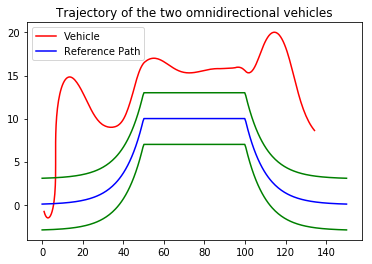

In [54]:
x_path = [[posx_path[i], lane(posx_path[i])[0], 10, lane(posx_path[i])[1]] for i in range(300)]
posx = []
posy = []
v = []
theta = []
for i in agent_traj[-1]:
    posx.append(i[0][0])
    posy.append(i[0][1])
    v.append(i[0][2])
    theta.append(i[0][3])
    
posx_ = np.asarray(x_path)[:, 0]
posy_ = np.asarray(x_path)[:, 1]

_ = plt.title("Trajectory of the two omnidirectional vehicles")
_ = plt.plot(posx, posy, "r")
_ = plt.plot(posx_, posy_, "b")
_ = plt.plot(posx_, posy_ + 3.0, 'g')
_ = plt.plot(posx_, posy_ - 3.0, 'g')
_ = plt.legend(["Vehicle", "Reference Path"])

Now implement the MPSC guided controller. MPSC solves feasiblity problem to verify the safety of each output of the regression model. Once the output is unsafe, then MPC solves an optimal control and overrides the regression model.

In [30]:
N = len(x_path)
H = 30  # Number of time steps in trajectory.
n = 30
n_init = 0
#n_end = 250
n_end = N - H - 1
x0 = x_path[n_init]  # Initial state.
# Random initial action path.
us_init = np.zeros((n - 1, dynamics.action_size))

J_hist = []
nn_traj = []
mpc_traj= []
traj = []

for i in range(n_init, n_end):
    print(">>>>>Step {} at {}".format(i, x0))
    x_path_ = x_path[i: i + H]
    x_nn = []
    for j in [x0] + x_path_[0 : n]:
        for k in j:
            x_nn.append(k)
    u = agent.run([x_nn])
    #print("NN outputs control")
    agent_traj = agent_traj + [[x0, u[0, :]]]
    x0_ = dynamics.f(x0, u[0], i)
    #print("Get next state")

    if i <= N - H - 1:
        n_ilqr =  H 
    else:
        n_ilqr = N - i - 1
    x_path_ilqr = x_path[i + 1: i + 1 + n_ilqr]
    #us_init = np.random.uniform(-1, 1, (n_ilqr - 1, dynamics.action_size))
    
    cost_ = CarCost(Q = Q, q = q, \
                   R = R, r = r, \
                   A = A, b = b, \
                   q1 = q1, q2 = q2, \
                   x_path = x_path_ilqr, \
                   x_nominal = nominal)
    ilqr_ = iLQR(dynamics, cost_, n_ilqr - 1)
    xs, us = ilqr_.fit(x0_, us_init, on_iteration=on_iteration)
    #print("MPC verifying")
    
    
    if (np.squeeze(\
        (xs - np.array([[x[0], nominal(x[0])[0], 10.0, x[1]] for x in xs])).dot(A[0].T) - b[0,0]\
                   <= 0)).all() == True and \
        (np.squeeze(\
        (xs - np.array([[x[0], nominal(x[0])[0], 10.0, x[1]] for x in xs])).dot(A[1].T) - b[1,0]\
                  <= 0)).all() == True:
        traj.append([x0, u[0, :]])
        nn_traj.append(traj[-1])
        print("Utilize NN output {}".format(u))
    else:
        max_itr = 5
        while (np.squeeze(\
        (xs - np.array([[x[0], nominal(x[0])[0], 10.0, x[1]] for x in xs])).dot(A[0].T) - b[0,0]\
                   <= 0)).any() == False or \
        (np.squeeze(\
        (xs - np.array([[x[0], nominal(x[0])[0], 10.0, x[1]] for x in xs])).dot(A[1].T) - b[1,0]\
                  <= 0)).any() == False :
            if max_itr == 0:
                break
            max_itr -= 1    
            cost = CarCost(Q = Q, q = q, \
                   R = R, r = r, \
                   A = A, b = b, \
                   q1 = q1, q2 = q2, \
                   x_path = x_path_, \
                   x_nominal = nominal)
            ilqr = iLQR(dynamics, cost, H)
            xs, us = ilqr.fit(x0, us_init, on_iteration=on_iteration)
        traj.append([x0, us[0]])
        mpc_traj.append(traj[-1])
        x0_ = dynamics.f(x0, us[0], i)
        print("Utilize MPC output {}".format(us[0]))
    x0 = x0_[0][:]

>>>>>Step 0 at [0.0, 0.067379469990854673, 10, 0.0067378450344227981]
iteration 0 accepted [ 0.02924184] [ 15.01840062   0.29547169  10.01244889   0.02122318] [-0.00053378 -0.003778  ]
Utilize NN output [[ 0.29570881 -0.00121071]]
>>>>>Step 1 at [  5.00347868e-01   7.07507874e-02   1.00143690e+01   6.13249154e-03]
iteration 0 accepted [ 0.03548132] [ 15.52904789   0.31069569  10.01650701   0.02011403] [-0.00049516 -0.00554806]


/usr/lib/python3/dist-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/lib/python3/dist-packages/torch/nn/functional.py:1374: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/depend/workspace/MPSC_Guided_Imitation_Learning/ilqr/ilqr/controller.py:168: UserWarning: exceeded max regularization term
  warnings.warn("exceeded max regularization term")


Utilize NN output [[ 0.28492764 -0.016281  ]]
>>>>>Step 2 at [  1.00140372e+00   7.38235467e-02   1.00282420e+01  -2.01898785e-03]
iteration 0 accepted [ 0.05168279] [ 16.04009404   0.32661342  10.02042863   0.02016344] [-0.00045044 -0.00654326]
Utilize NN output [[ 0.28186983 -0.0077549 ]]
>>>>>Step 3 at [  1.50315809e+00   7.28105094e-02   1.00419738e+01  -5.90730898e-03]
iteration 0 accepted [ 0.07787809] [ 16.55177314   0.34339504  10.02433999   0.02154019] [-0.00040809 -0.00664297]
Utilize NN output [[ 0.28053948  0.00201597]]
>>>>>Step 4 at [  2.00558977e+00   6.98424557e-02   1.00556440e+01  -4.89509367e-03]
iteration 0 accepted [ 0.11494265] [ 17.06393299   0.36108465  10.02812875   0.02318717] [-0.00035855 -0.00660524]
Utilize NN output [[ 0.27940017  0.00363858]]
>>>>>Step 5 at [  2.50870638e+00   6.73796331e-02   1.00692615e+01  -3.06569073e-03]
iteration 0 accepted [ 0.16356524] [ 17.5762628    0.37959569  10.03163758   0.02423003] [-0.0002936  -0.00705992]
Utilize NN outpu

Utilize NN output [[ 0.11015566  0.00720938]]
>>>>>Step 36 at [  1.83507246e+01   3.35910322e-01   1.03371416e+01   1.74131516e-02]
iteration 0 accepted [ 7.80581999] [ 33.47850458   1.80268955  10.0571233    0.12586091] [ 0.00403713 -0.02680756]
Utilize NN output [[ 0.10859043  0.00848021]]
>>>>>Step 37 at [ 18.86763846   0.34491233  10.34254991   0.0217961 ]
iteration 0 accepted [ 8.2924946] [ 33.98830276   1.89695905  10.05696893   0.13319093] [ 0.00417674 -0.02757551]
Utilize NN output [[ 0.10709006  0.0085012 ]]
>>>>>Step 38 at [ 19.38477645   0.35618571  10.34788404   0.0261922 ]
iteration 0 accepted [ 8.79482692] [ 34.49746452   1.99603301  10.05684246   0.14085392] [ 0.00431334 -0.02841428]
Utilize NN output [[ 0.1056623   0.00861327]]
>>>>>Step 39 at [ 19.90212473   0.3697393   10.35314758   0.03064854]
iteration 0 accepted [ 9.31223167] [ 35.00590014   2.1001153   10.05674406   0.14885143] [ 0.00444701 -0.02934   ]
Utilize NN output [[ 0.10416976  0.00860796]]
>>>>>Step 40 at

Utilize NN output [[ 0.22678769  0.01214576]]
>>>>>Step 72 at [ 36.95403614   2.52531993  10.55353332   0.27584936]
iteration 0 accepted [ 36.74669412] [ 50.42184036   9.87442764  10.24996726   0.42412425] [-0.00319882 -0.03469421]
Utilize NN output [[ 0.24932152  0.03104085]]
>>>>>Step 73 at [ 37.46205737   2.66912337  10.56574736   0.29222364]
iteration 0 accepted [ 38.05085074] [ 51.01220099   9.91044569  10.26388779   0.29726734] [-0.00407526  0.00127022]
Utilize NN output [[ 0.25814474  0.01867901]]
>>>>>Step 74 at [ 37.96825066   2.82140456  10.57837533   0.30209038]
iteration 0 accepted [ 39.33528214] [ 51.58782035   9.90112566  10.2758514    0.19880663] [-0.00472718  0.02909052]
Utilize NN output [[ 0.28749096  0.01330183]]
>>>>>Step 75 at [ 38.47355216   2.97887072  10.59236653   0.30912555]
iteration 0 accepted [ 40.48777408] [ 52.15385219   9.87247764  10.2877583    0.13383146] [-0.00535772  0.04961562]
Utilize NN output [[ 0.28896543  0.02385576]]
>>>>>Step 76 at [ 38.97840

Utilize NN output [[ 0.02496174 -0.05061325]]
>>>>>Step 107 at [ 54.3262632    9.39219677  10.78813923   0.1324193 ]
iteration 0 accepted [ 90.72587505] [  6.98340083e+01   9.98673946e+00   1.01694898e+01   2.80303208e-02] [ 0.00606473  0.02161565]
Utilize NN output [[ 0.02401955 -0.04374244]]
>>>>>Step 108 at [ 54.86097761   9.46342007  10.78933998   0.10883936]
iteration 0 accepted [ 93.40657688] [  7.03782718e+01   9.96634530e+00   1.01656869e+01   2.28626306e-02] [ 0.00631921  0.01763659]
Utilize NN output [[ 0.02324031 -0.03717664]]
>>>>>Step 109 at [ 55.39728137   9.52202261  10.79050179   0.08879303]
iteration 0 accepted [ 96.17159287] [  7.09201239e+01   9.94825463e+00   1.01616358e+01   1.85129934e-02] [ 0.00659776  0.01429506]
Utilize NN output [[ 0.022595   -0.03122888]]
>>>>>Step 110 at [ 55.93470912   9.56986826  10.79163134   0.07194974]
iteration 0 accepted [ 99.02261373] [  7.14602711e+01   9.93242318e+00   1.01574321e+01   1.48798717e-02] [ 0.00689145  0.01150621]
Util

Utilize NN output [[ 0.01427905 -0.00109864]]
>>>>>Step 138 at [  7.10503911e+01   1.01253974e+01   1.08158653e+01   2.64236847e-02]
iteration 0 accepted [ 217.53540422] [  8.64963510e+01   9.91170223e+00   1.00510467e+01   6.24629328e-03] [ 0.01430863  0.00518434]
Utilize NN output [[ 0.01416778 -0.00149209]]
>>>>>Step 139 at [  7.15910133e+01   1.01396859e+01   1.08165736e+01   2.56167754e-02]
iteration 0 accepted [ 223.13950317] [  8.70335109e+01   9.91073874e+00   1.00479575e+01   6.05197375e-03] [ 0.01451636  0.0050337 ]
Utilize NN output [[ 0.01405774 -0.00140047]]
>>>>>Step 140 at [  7.21316821e+01   1.01535392e+01   1.08172765e+01   2.48593597e-02]
iteration 0 accepted [ 228.84368248] [  8.75707318e+01   9.90982290e+00   1.00449070e+01   5.86830968e-03] [ 0.01472097  0.00489118]
Utilize NN output [[ 0.01395339 -0.00132457]]
>>>>>Step 141 at [  7.26723963e+01   1.01669837e+01   1.08179741e+01   2.41429497e-02]
iteration 0 accepted [ 234.64836799] [  8.81080155e+01   9.90894747e+

Utilize NN output [[ 0.01298894 -0.00049067]]
>>>>>Step 169 at [  8.78275231e+01   1.04678797e+01   1.08364078e+01   1.20376739e-02]
iteration 0 accepted [ 439.74366455] [  1.03173552e+02   9.85708209e+00   9.97183831e+00  -4.92193177e-03] [ 0.01943572  0.00449109]
Utilize NN output [[ 0.01301884 -0.00034753]]
>>>>>Step 170 at [  8.83693205e+01   1.04744020e+01   1.08370587e+01   1.18493759e-02]
iteration 0 accepted [ 448.98201197] [  1.03706287e+02   9.71005983e+00   9.96971148e+00  -9.06733231e-02] [ 0.01957124  0.02741727]
Utilize NN output [[ 0.0130494  -0.00025082]]
>>>>>Step 171 at [  8.89111517e+01   1.04808226e+01   1.08377111e+01   1.17134683e-02]
iteration 0 accepted [ 454.21909408] [ 104.18654521    9.33035514    9.96882479   -0.24423065] [ 0.01968716  0.06244318]
Utilize NN output [[ 0.01258693 -0.04197624]]
>>>>>Step 172 at [  8.94530158e+01   1.04871700e+01   1.08383404e+01  -1.10195013e-02]
iteration 0 accepted [ 461.85414283] [ 104.62185259    8.93759555    9.96695056  

Utilize NN output [[ 0.06640238 -0.12667276]]
>>>>>Step 202 at [ 104.34581534    8.39859101   10.81466401   -0.17941905]
iteration 0 accepted [ 142.51239387] [ 117.56875038    1.57777956   10.14393808   -0.21967801] [ 0.00921107 -0.00637631]
Utilize NN output [[ 0.0602785  -0.11901142]]
>>>>>Step 203 at [ 104.87794248    8.30207942   10.81767429   -0.24347036]
iteration 0 accepted [ 127.96586661] [ 117.9324366     1.44948306   10.16546132   -0.22580584] [ 0.00780329 -0.01968089]
Utilize NN output [[ 0.05412102 -0.10341424]]
>>>>>Step 204 at [ 105.40293962    8.17167117   10.8203777    -0.29920689]
iteration 0 accepted [ 118.40807939] [ 118.3310507     1.33763337   10.17976508   -0.23037117] [ 0.00690713 -0.03088861]
Utilize NN output [[ 0.04891137 -0.08583378]]
>>>>>Step 205 at [ 105.91997972    8.01218112   10.82282132   -0.34553088]
iteration 0 accepted [ 112.47978124] [ 118.76450131    1.23399174   10.18748776   -0.23321814] [ 0.00646602 -0.04022362]
Utilize NN output [[ 0.04448502 

Utilize NN output [[ 0.01014349  0.01630406]]
>>>>>Step 236 at [ 121.66179166    2.32649827   10.85315727   -0.17794101]
iteration 0 accepted [ 374.62887625] [  1.36586589e+02  -2.13942443e-01   9.99270418e+00  -7.00351301e-02] [ 0.0186036  -0.02672364]
Utilize NN output [[ 0.00997941  0.01522977]]
>>>>>Step 237 at [ 122.19589336    2.23044374   10.85365622   -0.16967709]
iteration 0 accepted [ 387.0760207] [  1.37152240e+02  -2.15416463e-01   9.98907830e+00  -6.67053326e-02] [ 0.01880385 -0.02554942]
Utilize NN output [[ 0.00982361  0.01420307]]
>>>>>Step 238 at [ 122.73079499    2.13880203   10.85414739   -0.16196985]
iteration 0 accepted [ 399.52122204] [  1.37716195e+02  -2.16672720e-01   9.98558638e+00  -6.35750842e-02] [ 0.01899623 -0.02446172]
Utilize NN output [[ 0.00967586  0.01324045]]
>>>>>Step 239 at [ 123.26641109    2.05128169   10.85463116   -0.15478458]
iteration 0 accepted [ 411.97456839] [  1.38278630e+02  -2.17734234e-01   9.98221744e+00  -6.06291730e-02] [ 0.0191813

Utilize NN output [[ 0.00793065  0.00180667]]
>>>>>Step 268 at [  1.38950071e+02   7.27740409e-01   1.08669360e+01  -4.49274557e-02]
iteration 0 accepted [ 793.50511629] [  1.54263647e+02  -1.46151611e-01   9.91573141e+00  -1.60765912e-02] [ 0.02264241 -0.00745473]
Utilize NN output [[ 0.0079203   0.00194465]]


The red curve in the plot is the trajecotry of the hybrid controller. It can be seen that the vehicle still drive out of the lane boundaries even with the existence of the MPSC. It is because horizon being 30 is too short to predict the unsafe outcome and prevent the vehicle from moving out of the boundary.

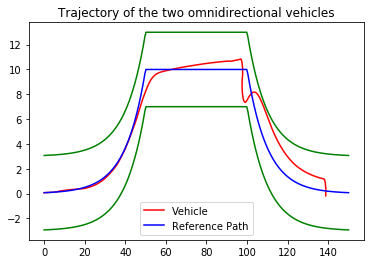

In [137]:
posx = []
posy = []
v = []
theta = []
for i in traj:
    posx.append(i[0][0])
    posy.append(i[0][1])
    v.append(i[0][2])
    theta.append(i[0][3])
    
posx_ = np.asarray(x_path)[:, 0]
posy_ = np.asarray(x_path)[:, 1]

_ = plt.title("Trajectory of the two omnidirectional vehicles")
_ = plt.plot(posx, posy, "r")
_ = plt.plot(posx_, posy_, "b")
_ = plt.plot(posx_, posy_ + 3.0, 'g')
_ = plt.plot(posx_, posy_ - 3.0, 'g')
_ = plt.legend(["Vehicle", "Reference Path"])



The red dots are the steering commands output by the regression model while the blue dots are from the MPC.

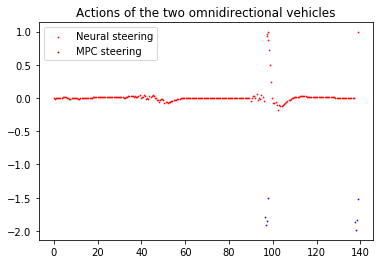

In [135]:

str_nn = []
posx_nn = []
str_mpc = []
posx_mpc = []
for i in nn_traj:
    posx_nn.append(i[0][0])
    str_nn.append(i[1][1])
for j in mpc_traj:
    posx_mpc.append(j[0][0])
    str_mpc.append(j[1][1])
    

_ = plt.title("Actions of the two omnidirectional vehicles")
_ = plt.scatter(posx_nn, str_nn, s = 0.5, c = "r")
_ = plt.scatter(posx_mpc, str_mpc, s = 0.5, c = "b")
_ = plt.legend(["Neural steering", "MPC steering"])

MPSC Guided Learning
=====================

I have considered two algorithms different from what we have discussed. Instead of filtering the learning-based controller's output during deploying phase, MPC can be used as a filter during training phase. The ultimate goal is that the learning model maintains high performance while avoiding performing unsafe behavior.

The basic set up is that the environment has state space $X$, control space $U$ as well as the known, perhaps nonlinear dynamics $x_{k+1} = f(x_k, u_k)$ where $x_k,u_k$ are current state and action pairs and $x_{k+1}$ is next state. Given a learning based controller $g:X\times \Theta\rightarrow U$ where $\Theta$ is the parameter space, a set of trajectories $\{\tau_i|\tau_i=(x^{(i)}_0, u^{(i)}_0, x^{(i)}_1, u^{(i)}_1, \ldots)\}$ can be obtained by executing $g$. Define the convex set of safe states $\{x|x\in X, UNSAFE(x)\leq 0\}$. Assume that an unsafe controller $g$ is at hand. It can generate at least one trajectory $\tau=(x_0, a_0, x_1, a_1, \ldots x_T, a_T\}$ that reaches an unsafe state.

The algorithm is inspired by the motivation of iLQR, which is to linearize the nonlinear dynamics. Given one trajectory $\tau$, a perturbation can be added to this trajectory, i.e. $x_k\rightarrow x_k + \delta x_k, u_k\rightarrow u_k +\delta u_k$. Then the relationship between $\delta x_k,\delta u_k$ can be obtained as follows.

\begin{eqnarray}
x_{k+1} &=& f(x_k, u_k)\\
x_{k+1} \delta x_{k+1} &=& f(x_k+\delta x_k, u_k + \delta u_k) \\
\delta x_{k+1} &=& f(x_k+\delta, u_k + \delta u_k) - f(x_k, u_k)\\
&\approx& \nabla_x f(x_k, u_k) \delta x_k + \nabla_u f(x_k, u_k) \delta u_k
\end{eqnarray}


<h2>MPSC Guided Policy Search</h2>

Usually, learning-based controller upates its model parameter iteratively during the training phase. We can use MPSC to filter the update. It is already known that $u_k=g(x_k, \theta)$.Then the following equation holds.

\begin{eqnarray}
u_k &=& g(x_k, \theta)\\
u_k + \delta u_k &=& g(x_k + \delta x_k, \theta + \delta \theta)\\
\delta u_k &\approx& \nabla_x g(x_k, \theta) \delta x_k + \nabla_\theta g(x_k, \theta) \delta \theta
\end{eqnarray}

Then interpolate it into the linearized dynmics. 
$$\delta x_{k+1} \approx [\nabla_x f(x_k, u_k)  + \nabla_u f(x_k, u_k) \nabla_x g(x_k, \theta) ]\delta x_k + \nabla_u f(x_k, u_k) \nabla_\theta g(x_k, \theta) \delta \theta$$


At this end, we can determine our MPSC problem as, finding the minimal perturbation on the learning model parameters such that the unsafe trajecotries becomes safe.
\begin{eqnarray}
\underset{\delta\theta}{min}&&||\delta \theta||_2^2 \\
s.t. && \delta x_{k+1} = [\nabla_x f(x_k, u_k)  + \nabla_u f(x_k, u_k) \nabla_x g(x_k, \theta) ]\delta x_k + \nabla_u f(x_k, u_k) \nabla_\theta g(x_k, \theta) \delta \theta\qquad k=0, 1, 2, \ldots, T\\
&& \delta x_0 = 0\\
&& UNSAFE(x_k+\delta x_k)\leq 0\qquad k=0, 1, 2, \ldots, T
\end{eqnarray}

In practice, the solved $\delta \theta$ can be applied to the learning model parameter in every iteration. For instance, when using policy gradient to train a parameterized policy $\pi_\theta: X\rightarrow U$, after every gradient step $\theta_{i-1} \rightarrow \theta_{i}$, the resulted policy $\pi_{\theta_i}$ is used to generated samples for the next optimization. Then MPC formulated above can be implemented to the unsafe trajectories (or multiple trajecotries nearby the unsafe set) to further update the policy parameter $\theta_i\rightarrow \theta_i + \delta \theta_i$. 




<h2>MPSC Guided Imitation Learning</h2>


Following the afformentioned basic setup, we can use MPSC in imitation learning, not to perturb the model parameter, but perturb the cost function based on the intermediate sample trajectories. 
It is known that the original IRL formula is 
$$\underset{c}{min}\ \underset{\pi}{max}\ \mathbb{E}_{\pi_E}[c(x, u)] - \mathbb{E}_{\pi} [c(x, u)]$$

It is common in model-free approaches that whenever a new intermediate policy $\pi_{\theta_i}$ is obtained, a set of corresponding sample trajecotries are generated to compare with the expert trajectories $E$ and update the cost function. For instance, in WGAN formulated GAIL, the update of the discriminator $D: X\times U\times W\rightarrow \mathbb{R}$ with parameter space $W$ is as follows.

$$\underset{w\in W}{min}\ \mathbb{E}_{(x,u)\sim \pi_E}[D(x, u, w)] - \mathbb{E}_{(x,u)\sim\pi_{\theta_i}} [D(x, u, w)]$$




Our first step is to find the minimal perturbation to the unsafe intermediate sample trajectories while maintaining high performance. Given an unsafe trajecotry $\tau=(x_0,u_0, \ldots, x_T, u_T)$, the quadratic cost matrices $Q, R$ standard for iLQR are obtained from the current cost $D(, ,w_{i-1})$. Then the MPSC problem is as follows.
\begin{eqnarray}
\underset{\delta x, \delta u}{min} && \delta x^T Q \delta x + \delta u^T R \delta u \\
s.t. && \delta x_{k+1} \approx \nabla_x f(x_k, u_k) \delta x_k + \nabla_u f(x_k, u_k) \delta u_k \qquad k=0, 1, 2, \ldots, T\\
&& \delta x_0 = 0\\
&& UNSAFE(x_k+\delta x_k)\leq 0\qquad k=0, 1, 2, \ldots, T
\end{eqnarray}

Then a constraint can be added to the optimal cost problem such that the perturbed trajecotry $\tau+\delta\tau$ has lower cost than $\tau$. 

\begin{eqnarray}
\underset{w}{min}& &\mathbb{E}_{(x,u)\sim \pi_E}[D(x, u, w)] - \mathbb{E}_{(x,u)\sim\pi_{\theta_i}} [D(x, u, w_{i-1})]\\
s.t. && \sum_{(x_k+\delta x_k,u_k + \delta u_k)\in \tau+\delta_\tau} D(x_k + \delta x_k,u_k + \delta u_k, w) - \sum_{(x_k,u_k)\in \tau} D(x_k,u_k, w)  \leq 0
\end{eqnarray}

However, since $\tau$ is optimal w.r.t the $\pi_{\theta_i}$ which is optimal w.r.t $D(,, w_{i-1})$, the constraint is mostly unlike to be satisfied under $w_{i-1}$. In other word, the constraint of the problem changes in every iteration and the problem can be infeasible in the beginning of every iteration. To simplify the problem, the constraint can be manipulated as follows.

If function $D$ is convex in terms of $x, u$, then subgradient can be used.
\begin{eqnarray}
&&\sum_{(x_k,u_k)\in \tau} D(x_k,u_k, w) - \sum_{(x_k+\delta x_k,u_k + \delta u_k)\in \tau+\delta_\tau} D(x_k+\delta x_k,u_k + \delta u_k, w)  \geq 0\\
&\Rightarrow& \underset{g^{(k)}_i\in \partial_{(x, u)} D(x_k+\delta x_k, u_k + \delta u_k ,w)}{min}\  \sum_{(x_k,u_k)\in\tau} g^{(k)}_i \cdot [-\delta x_k, - \delta u_k]^T\geq 0 
\end{eqnarray}

However, it can be problemetic to find the minimal subgradient in practice. The second proposal does not require convexity to be guaranteed. In every iteration, we can consider two cases. 

If $\sum_{\tau + \delta\tau} D(x_k + \delta x_k,u_k + \delta u_k, w_{i-1}) - \sum_{\tau} D(x_k,u_k, w_{i-1}) \geq 0$, which implies that $w_{i-1}$ is feasible, then directly use barrier or penalty method to update $w_{i-1}$. 

If $\sum_{\tau + \delta\tau} D(x_k + \delta x_k,u_k + \delta u_k, w_{i-1}) - \sum_{\tau} D(x_k,u_k, w_{i-1}) \leq 0$, then the constraint can be tightened by borrowing the left hand side of the inequality. Assume that a feasible update $\delta w_{i-1}$ on $w_{i-1}$ enables $w_i = w_{i-1} + \delta w_{i-1}$ to satisfy the tightened constraint as below.

\begin{eqnarray}
&&\sum_{\tau+\delta_\tau} D(x_k + \delta x_k,u_k + \delta u_k, w_{i-1} + \delta w_{i-1}) - \sum_{\tau} D(x_k,u_k, w_{i-1} + \delta w_{i-1})\leq \sum_{\tau + \delta\tau} D(x_k + \delta x_k,u_k + \delta u_k, w_{i-1}) - \sum_{\tau} D(x_k,u_k, w_{i-1}) \\
&&\sum_{\tau+\delta_\tau} D(x_k + \delta x_k,u_k + \delta u_k, w_{i-1} + \delta w_{i-1}) - \sum_{\tau + \delta\tau} D(x_k,u_k, w_{i-1}) + \sum_{\tau} D(x_k,u_k, w_{i-1})- \sum_{\tau} D(x_k,u_k, w_{i-1} + \delta w_{i-1})  \leq 0\\
&&\nabla_w \sum_{\tau + \delta\tau} D(x_k + \delta x_k,u_k + \delta u_k, w_{i-1})\delta w_{i-1} - \nabla_w \sum_{\tau} D(x_k,u_k, w_{i-1})\delta  w_{i-1}\leq 0\\
&&\nabla_w \sum_{\tau} [D(x_k + \delta x_k,u_k + \delta u_k, w_{i-1}) - D(x_k,u_k, w_{i-1})]\delta w_{i-1}\leq 0
\end{eqnarray}

As a result, the constraint is linearized. The direction of $\delta w_{i-1}$ can be determined by the gradient of the object while the step length is confined by this linear constraint.
